In [1]:
import os
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

In [2]:
def read_all_tfevents(root_log_dir):
    all_data = []
    # Iterate over subdirectories in the root log directory
    for experiment in os.listdir(root_log_dir):
        experiment_dir = os.path.join(root_log_dir, experiment)
        # Ensure it's a directory (i.e. an experiment folder)
        if os.path.isdir(experiment_dir):
            # Check if there are any event files in this folder
            tfevents_files = [f for f in os.listdir(experiment_dir) if "tfevents" in f]
            if not tfevents_files:
                continue  # Skip folders with no event files
            # Initialize the event accumulator for this experiment folder.
            ea = event_accumulator.EventAccumulator(experiment_dir, size_guidance={'scalars': 0})
            ea.Reload()
            # Extract scalar data for each tag
            for tag in ea.Tags().get('scalars', []):
                for event in ea.Scalars(tag):
                    all_data.append({
                        "experiment": experiment,
                        "tag": tag,
                        "step": event.step,
                        "value": event.value,
                        "wall_time": event.wall_time,
                    })
    # Convert the accumulated list into a pandas DataFrame
    return pd.DataFrame(all_data)


In [3]:
log_dir = "/Users/peterochek/Downloads/tensorboard_logs"
df = read_all_tfevents(log_dir)

print("Combined DataFrame preview:")
print(df.head())

Combined DataFrame preview:
                            experiment         tag  step     value  \
0  sasrec_full_beauty_2025-03-15T14:29  train/loss     0  9.414660   
1  sasrec_full_beauty_2025-03-15T14:29  train/loss     1  9.386642   
2  sasrec_full_beauty_2025-03-15T14:29  train/loss     2  9.396064   
3  sasrec_full_beauty_2025-03-15T14:29  train/loss     3  9.386980   
4  sasrec_full_beauty_2025-03-15T14:29  train/loss     4  9.392842   

      wall_time  
0  1.742038e+09  
1  1.742038e+09  
2  1.742038e+09  
3  1.742038e+09  
4  1.742038e+09  


In [4]:
today_df = df[pd.to_datetime(df.wall_time * 1e6, unit='us') >= pd.to_datetime('2025-03-15')]
today_df = today_df[today_df.experiment.str.contains('loo')]
today_df[today_df.tag.str.contains('@') & today_df.tag.str.contains('eval')].groupby(['experiment', 'tag']).agg({'value': 'max'})

value
experiment                                         tag                       
sasrec_full_beauty_loo_2025-03-15T13:14            eval/coverage@10  0.968846
                                                   eval/coverage@20  0.984629
                                                   eval/coverage@5   0.930171
                                                   eval/ndcg@10      0.042984
                                                   eval/ndcg@20      0.050907
                                                   eval/ndcg@5       0.034824
                                                   eval/recall@10    0.081474
                                                   eval/recall@20    0.114296
                                                   eval/recall@5     0.054018
sasrec_in_batch_beauty_loo_2025-03-15T13:14        eval/coverage@10  0.995124
                                                   eval/coverage@20  0.996860
                                                   eval/coverage@5   0.983307
                                                   eval/ndcg@10      0.027490
                                                   eval/ndcg@20      0.034438
                                                   eval/ndcg@5       0.020459
                                                   eval/recall@10    0.061083
                                                   eval/recall@20    0.088405
                                                   eval/recall@5     0.038143
sasrec_real_beauty_loo_2025-03-15T13:14            eval/coverage@10  0.940749
                                                   eval/coverage@20  0.975126
                                                   eval/coverage@5   0.878109
                                                   eval/ndcg@10      0.020057
                                                   eval/ndcg@20      0.027746
                                                   eval/ndcg@5       0.013187
                                                   eval/recall@10    0.049233
                                                   eval/recall@20    0.079238
                                                   eval/recall@5     0.026741
sasrec_semantic_learnable_uid_beauty_loo_2025-0... eval/coverage@10  0.931906
                                                   eval/coverage@20  0.963722
                                                   eval/coverage@5   0.866705
                                                   eval/ndcg@10      0.027434
                                                   eval/ndcg@20      0.033892
                                                   eval/ndcg@5       0.020945
                                                   eval/recall@10    0.054510
                                                   eval/recall@20    0.080088
                                                   eval/recall@5     0.034432

In [9]:
import pandas as pd
import re

# Suppose today_df is defined as:
# today_df = df[pd.to_datetime(df.wall_time * 1e6, unit='us') >= pd.to_datetime('2025-03-15')]

# First, filter rows where tag contains both '@' and 'eval'
filtered = today_df[today_df.tag.str.contains('@') & today_df.tag.str.contains('eval')].copy()

# Function to extract metric and cutoff from the tag string
def extract_metric_cutoff(tag):
    # This regex looks for a word (metric) followed by '@' and then a number (cutoff)
    match = re.search(r'(\w+)[@](\d+)', tag)
    if match:
        metric = match.group(1)
        cutoff = int(match.group(2))
        return metric, cutoff
    return None, None

# Apply the function to extract 'metric' and 'cutoff' and create new columns.
filtered[['metric', 'cutoff']] = filtered['tag'].apply(
    lambda x: pd.Series(extract_metric_cutoff(x))
)

# Group by experiment, metric, and cutoff and compute the max value.
grouped = (
    filtered.groupby(['experiment', 'metric', 'cutoff'])['value']
    .max()
    .reset_index()
)

# Option 1: If you want a single table with all metrics, you can keep this long format.
print("Grouped DataFrame (long format):")
print(grouped.head())
grouped.experiment = grouped.experiment.str.replace('sasrec_', '')
grouped.experiment = grouped.experiment.str.replace('_beauty_loo.*', '', regex=True)
grouped.value = grouped.value.astype(float).round(3)
    

# Option 2: Alternatively, pivot the table so that each metric gets its own pivot table.
pivot_tables = {}
for metric, group in grouped.groupby('metric'):
    pivot = group.pivot(index='experiment', columns='cutoff', values='value')
    pivot_tables[metric] = pivot


Grouped DataFrame (long format):
                                experiment    metric  cutoff     value
0  sasrec_full_beauty_loo_2025-03-15T13:14  coverage       5  0.930171
1  sasrec_full_beauty_loo_2025-03-15T13:14  coverage      10  0.968846
2  sasrec_full_beauty_loo_2025-03-15T13:14  coverage      20  0.984629
3  sasrec_full_beauty_loo_2025-03-15T13:14      ndcg       5  0.034824
4  sasrec_full_beauty_loo_2025-03-15T13:14      ndcg      10  0.042984


In [10]:
print(pivot_tables.keys())
for k in pivot_tables.keys():
    reset = pivot_tables[k].reset_index()
    pivot_tables[k] = reset.sort_values(5, ascending=False)

dict_keys(['coverage', 'ndcg', 'recall'])


In [11]:
pd.concat(pivot_tables.values(), axis=0).to_excel('../results.xlsx')

In [12]:
pivot_tables

{'coverage': cutoff              experiment      5     10     20
 1                     in_batch  0.983  0.995  0.997
 0                         full  0.930  0.969  0.985
 2                         real  0.878  0.941  0.975
 3       semantic_learnable_uid  0.867  0.932  0.964,
 'ndcg': cutoff              experiment      5     10     20
 0                         full  0.035  0.043  0.051
 3       semantic_learnable_uid  0.021  0.027  0.034
 1                     in_batch  0.020  0.027  0.034
 2                         real  0.013  0.020  0.028,
 'recall': cutoff              experiment      5     10     20
 0                         full  0.054  0.081  0.114
 1                     in_batch  0.038  0.061  0.088
 3       semantic_learnable_uid  0.034  0.055  0.080
 2                         real  0.027  0.049  0.079}

In [21]:
grouped

,experiment,metric,cutoff,value
0,full,coverage,5,0.930
1,full,coverage,10,0.969
2,full,coverage,20,0.985
3,full,ndcg,5,0.035
4,full,ndcg,10,0.043
5,full,ndcg,20,0.051
6,full,recall,5,0.054
7,full,recall,10,0.081
8,full,recall,20,0.114
9,in_batch,coverage,5,0.983


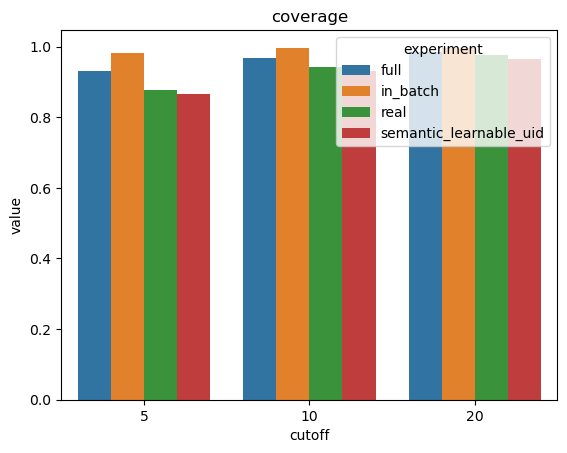

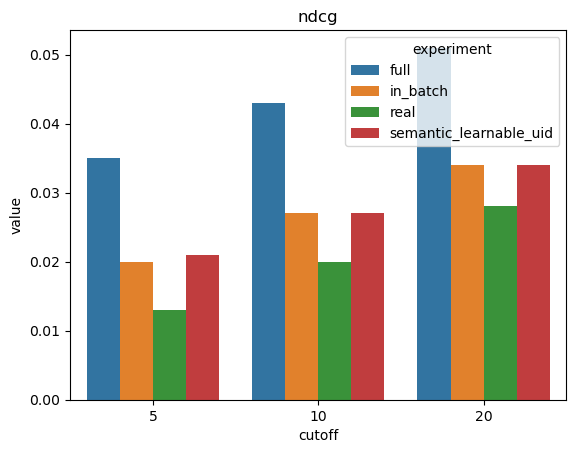

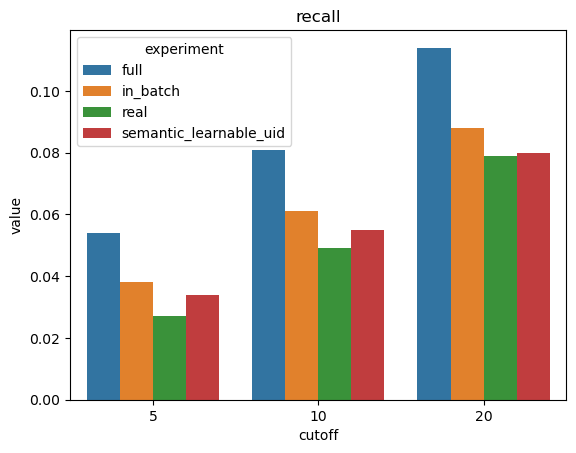

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

for metric in grouped.metric.unique():
    sns.barplot(
        x="cutoff",
        y="value",
        hue="experiment",
        data=grouped[grouped.metric == metric],
        errorbar=None
    )
    plt.title(metric)
    plt.show()

In [49]:
import re
from datetime import datetime

def extract_arxiv_dates(text):
    submission_pattern = r"Submitted on (\d{1,2} \w{3} \d{4})"
    revision_pattern = r"last revised (\d{1,2} \w{3} \d{4})"

    submission_match = re.search(submission_pattern, text)
    revision_match = re.search(revision_pattern, text)

    if submission_match:
        sub_date_str = submission_match.group(1)
        sub_date_formatted = datetime.strptime(sub_date_str, "%d %b %Y").strftime("%d.%m.%Y")
    else:
        sub_date_formatted = "N/A"

    if revision_match:
        rev_date_str = revision_match.group(1)
        rev_date_formatted = datetime.strptime(rev_date_str, "%d %b %Y").strftime("%d.%m.%Y")
    else:
        rev_date_formatted = "N/A"
    
    return sub_date_formatted, rev_date_formatted

In [54]:
# arxiv parser
import requests
from lxml import html
from datetime import datetime

def fetch_arxiv_metadata(pdf_url):
    # Convert the PDF URL to the abstract page URL
    abs_url = pdf_url.replace('/pdf/', '/abs/')
    
    # Fetch the abstract page
    response = requests.get(abs_url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve URL: {abs_url}")
    
    # Parse the HTML content
    tree = html.fromstring(response.content)
    
    # Define XPath expressions based on the provided page structure
    title_xpath = '//*[@id="abs"]/h1/text()'
    # The date is assumed to be in the format "6 Jun 2018"
    date_xpath = '//*[@id="abs"]/div[1]'
    # There can be several authors; extract all author names
    authors_xpath = '//*[@id="abs"]/div[2]/a'
    
    # Extract data using the defined XPaths
    title_list = tree.xpath(title_xpath)
    date_list = tree.xpath(date_xpath)
    authors_list = tree.xpath(authors_xpath)
    
    title = title_list[0].strip() if title_list else "N/A"
    date_text = extract_arxiv_dates(date_list[0].text_content()) if date_list else "N/A"
    authors = [author.text_content() for author in authors_list]
    
    # Convert date from textual format (e.g., "6 Jun 2018") to digit-only format ("06.06.2018")
    try:
        parsed_date = datetime.strptime(date_text, "%d %b %Y")
        formatted_date = parsed_date.strftime("%d.%m.%Y")
    except Exception as e:
        formatted_date = date_text  # Fallback to original text if conversion fails
    
    # Build the output string as "title / author1, author2, ... / formatted_date / original_pdf_url"
    authors_str = ", ".join(authors[:4])
    output = f"{title} / {authors_str} / {formatted_date[0]} / {pdf_url}"
    
    return output

if __name__ == "__main__":
    pdf_urls = [
        "2305.05065",
        "2306.08121",
        "1711.00937",
        "2404.00245",
        "1511.06939",
        "1808.09781",
        "1904.06690",
        "2008.07873",
        "2204.06519",
        "1806.01973",
        "1606.07792",
        "2205.04507",
        "2205.11728",
        "1706.02216",
        "1806.01973",
        "1905.08108",
        "2002.02126",
        "1706.03762",
        "2011.02260",
        "1808.09781",
        "1904.06690",
        "1810.04805"
    ]
    for pdf_url in set(pdf_urls):
        pdf_url = f"https://arxiv.org/pdf/{pdf_url}"
        result = fetch_arxiv_metadata(pdf_url)
        print(result)


CARCA: Context and Attribute-Aware Next-Item Recommendation via Cross-Attention / Ahmed Rashed, Shereen Elsayed, Lars Schmidt-Thieme / 04.04.2022 / https://arxiv.org/pdf/2204.06519
Attention Is All You Need / Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit / 12.06.2017 / https://arxiv.org/pdf/1706.03762
Wide & Deep Learning for Recommender Systems / Heng-Tze Cheng, Levent Koc, Jeremiah Harmsen, Tal Shaked / 24.06.2016 / https://arxiv.org/pdf/1606.07792
Recommender Systems with Generative Retrieval / Shashank Rajput, Nikhil Mehta, Anima Singh, Raghunandan H. Keshavan / 08.05.2023 / https://arxiv.org/pdf/2305.05065
Graph Neural Networks in Recommender Systems: A Survey / Shiwen Wu, Fei Sun, Wentao Zhang, Xu Xie / 04.11.2020 / https://arxiv.org/pdf/2011.02260
LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation / Xiangnan He, Kuan Deng, Xiang Wang, Yan Li / 06.02.2020 / https://arxiv.org/pdf/2002.02126
BERT4Rec: Sequential Recommendation with Bidirect

In [5]:
from dataset.base import BaseDataset
from dataloader.base import BaseDataloader
from models.base import BaseModel
import json
import torch
from torchviz import make_dot

config = json.load(open('../configs/train/rqvae_train_config.json'))


dataset = BaseDataset.create_from_config(config["dataset"])

train_sampler, validation_sampler, test_sampler = dataset.get_samplers()

train_dataloader = BaseDataloader.create_from_config(
    config["dataloader"]["train"], dataset=train_sampler, **dataset.meta
)

validation_dataloader = BaseDataloader.create_from_config(
    config["dataloader"]["validation"], dataset=validation_sampler, **dataset.meta
)

eval_dataloader = BaseDataloader.create_from_config(
    config["dataloader"]["validation"], dataset=test_sampler, **dataset.meta
)

model = BaseModel.create_from_config(config["model"], **dataset.meta)

Codebooks initialized with Faiss Kmeans


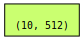

In [9]:
x = {"embeddings": torch.randn(10, 512)}
y = model(x)

make_dot(y['embeddings'], params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [11]:
print(model)

RqVaeModel(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=False)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=False)
  )
  (codebooks): ParameterList(
      (0): Parameter containing: [torch.float32 of size 256x64]
      (1): Parameter containing: [torch.float32 of size 256x64]
      (2): Parameter containing: [torch.float32 of size 256x64]
  )
)
